In [7]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score

# --- Installation Note ---
# !pip install tabpfn sklearn pandas seaborn matplotlib tqdm

print("Setup Complete!")

Setup Complete!


In [8]:
# ===================================================================
# Cell 2: Modified SOM (iSOM) Class from Research Paper (Corrected)
# ===================================================================

class ModifiedSOM:
    """
    An implementation of the modified Self-Organizing Map (iSOM) algorithm
    from the paper "Design Space Exploration and Optimization Using
    Self Organizing Maps". This version is adapted for classification tasks.
    """
    def __init__(self, x_dim, y_dim, n_iterations=100, learning_rate=0.5):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_nodes = x_dim * y_dim
        self.n_iterations = n_iterations
        self.alpha_0 = learning_rate
        self._data_mean = None
        self._data_std = None
        self.weights = None
        self.n_features = None

    def _initialize_weights(self, data):
        """
        Initializes weights using PCA. This version is robust to data
        with fewer than 2 principal components.
        """
        self.weights = np.zeros((self.x_dim, self.y_dim, data.shape[1]))
        
        # Avoid PCA on tiny datasets
        if data.shape[0] < 2:
            print("Warning: Not enough data for PCA. Using random initialization.")
            self.weights = np.random.rand(self.x_dim, self.y_dim, data.shape[1])
            return

        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # Filter out near-zero eigenvalues for stability
        valid_eigens = eigenvalues > 1e-9
        eigenvalues = eigenvalues[valid_eigens]
        eigenvectors = eigenvectors[:, valid_eigens]
        
        sorted_indices = np.argsort(eigenvalues)[::-1]

        if eigenvectors.shape[1] >= 2:
            # Standard case: Use top 2 principal components
            principal_components = eigenvectors[:, sorted_indices[:2]]
            grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, self.x_dim), np.linspace(-1, 1, self.y_dim))
            
            for i in range(self.x_dim):
                for j in range(self.y_dim):
                    vec = grid_x[j, i] * principal_components[:, 0] + grid_y[j, i] * principal_components[:, 1]
                    self.weights[i, j] = vec * np.std(data, axis=0) + np.mean(data, axis=0)

        elif eigenvectors.shape[1] == 1:
            # Fallback for 1-dimensional data: initialize along the single principal component
            print("Warning: Data has only one principal component. Initializing SOM along a line.")
            principal_component = eigenvectors[:, sorted_indices[0]]
            grid_scalars = np.linspace(-1, 1, self.n_nodes)
            
            flat_weights = self.weights.reshape(-1, data.shape[1])
            for i in range(self.n_nodes):
                vec = grid_scalars[i] * principal_component
                flat_weights[i] = vec * np.std(data, axis=0) + np.mean(data, axis=0)
            self.weights = flat_weights.reshape(self.x_dim, self.y_dim, data.shape[1])
        
        else:
            # Fallback to random initialization if no principal components are found
            print("Warning: Could not determine principal components. Using random initialization.")
            self.weights = np.random.rand(self.x_dim, self.y_dim, data.shape[1])

                
    def _find_bmu(self, x_sample):
        input_weights = self.weights[:, :, :self.n_features]
        distances = np.linalg.norm(input_weights - x_sample, axis=2)
        return np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    def fit(self, X, y):
        self.n_features = X.shape[1]
        y = y.reshape(-1, 1)
        
        full_data = np.hstack((X, y))
        self._data_mean = np.mean(full_data, axis=0)
        self._data_std = np.std(full_data, axis=0)
        self._data_std[self._data_std == 0] = 1
        
        normalized_data = (full_data - self._data_mean) / self._data_std
        X_norm = normalized_data[:, :self.n_features]
        y_norm = normalized_data[:, -1]

        self._initialize_weights(normalized_data)
        
        p = len(X_norm)
        t_max = self.n_iterations
        total_steps = p * t_max
        C = p / 100.0
        sigma_0 = max(self.x_dim, self.y_dim) / 2.0

        grid_coords = np.indices((self.x_dim, self.y_dim)).transpose(1, 2, 0)
        
        for t in range(t_max):
            for i in range(p):
                s = t * p + i
                bmu_coords = self._find_bmu(X_norm[i])
                
                sigma_s = sigma_0 * (1 - s / total_steps)
                L_s = C * (self.alpha_0 / (C + s))

                dist_to_bmu = np.linalg.norm(grid_coords - bmu_coords, axis=2)
                phi_s = np.exp(-dist_to_bmu**2 / (2 * sigma_s**2))

                error = y_norm[i] - self.weights[:, :, -1]
                self.weights[:, :, -1] += L_s * phi_s * error
                
                feature_error = X_norm[i] - self.weights[:, :, :-1]
                self.weights[:, :, :-1] += L_s * phi_s[:, :, np.newaxis] * feature_error


    def get_prototypes(self):
        if self.weights is None:
            raise RuntimeError("The SOM has not been trained yet.")
        
        synthetic_data_norm = self.weights.reshape(-1, self.n_features + 1)
        return synthetic_data_norm * self._data_std + self._data_mean

In [9]:
# ===================================================================
# Cell 3: ADVANCED Balanced iSOM Synthetic Data Generator
# ===================================================================
# This advanced generator improves upon the unified iSOM by using more
# sophisticated techniques to create higher-quality, more diverse data.

def generate_isom_data_unified(df_real, target_column, num_synthetic_total):
    if num_synthetic_total <= 0:
        return pd.DataFrame(columns=df_real.columns)

    print(f"Generating {num_synthetic_total} ADVANCED synthetic samples using iSOM...")
    
    X = df_real.drop(columns=[target_column]).values
    y = df_real[target_column].values
    feature_names = df_real.drop(columns=[target_column]).columns

    # Use a slightly smaller grid size for stability on small datasets
    num_prototypes = max(len(df_real), num_synthetic_total // 2)
    map_x = int(np.sqrt(num_prototypes))
    map_y = int(num_prototypes / map_x)
    if map_x == 0 or map_y == 0:
        print("Warning: Too few samples to generate data. Returning empty DataFrame.")
        return pd.DataFrame(columns=df_real.columns)

    # 1. Train the iSOM
    isom = ModifiedSOM(x_dim=map_x, y_dim=map_y, n_iterations=100)
    isom.fit(X, y)
    
    weights = isom.weights # Shape: (map_x, map_y, n_features + 1)
    
    # 2. Generate new samples using advanced techniques
    synthetic_samples = []
    rng = np.random.default_rng(42)

    for _ in range(num_synthetic_total):
        # Pick a random prototype from the grid
        rand_x, rand_y = rng.integers(0, map_x), rng.integers(0, map_y)
        p1 = weights[rand_x, rand_y]

        # Find its neighbors on the grid
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0: continue
                nx, ny = rand_x + dx, rand_y + dy
                if 0 <= nx < map_x and 0 <= ny < map_y:
                    neighbors.append(weights[nx, ny])
        
        # Pick a random neighbor for interpolation
        p2 = rng.choice(neighbors)

        # 3. Create a new sample via interpolation
        alpha = rng.random()
        new_sample = alpha * p1 + (1 - alpha) * p2

        # 4. Probabilistic Class Assignment
        # Denormalize the target value to get the probability
        target_prob_norm = new_sample[-1]
        target_prob = target_prob_norm * isom._data_std[-1] + isom._data_mean[-1]
        target_prob = np.clip(target_prob, 0, 1) # Ensure it's a valid probability
        
        # Assign class based on this probability
        final_class = rng.binomial(1, target_prob)

        # 5. Add controlled noise to features
        features = new_sample[:-1]
        # Denormalize features before adding noise
        features_denorm = features * isom._data_std[:-1] + isom._data_mean[:-1]
        # Add small noise (1% of the feature's standard deviation)
        noise = rng.normal(0, 0.01 * np.std(X, axis=0))
        final_features = features_denorm + noise
        
        # Combine final features and class
        final_row = np.append(final_features, final_class)
        synthetic_samples.append(final_row)

    # Create the final DataFrame
    final_synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    # Ensure target column is the correct integer type
    final_synthetic_df[target_column] = final_synthetic_df[target_column].astype(int)
    
    return final_synthetic_df

In [10]:
# ===================================================================
# Cell 4: Helper Functions (Data Loading)
# ===================================================================

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path, dataset_name):
    with open(os.path.join(base_path, dataset_name, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, dataset_name, f"{dataset_name}.{meta['format']}"))
    
    test_path = os.path.join(base_path, dataset_name, f"{dataset_name}_test.{meta['format']}")
    if os.path.exists(test_path):
        print(f"Found dedicated test set for {dataset_name}.")
        test_data = read_data(test_path)
    else:
        print(f"No dedicated test set for {dataset_name}. Splitting will be handled by index file.")
        test_data = None
        
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, dataset_name, repeat_idx):
    train_idx_file = os.path.join(base_path, dataset_name, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values

In [11]:
# ===================================================================
# Cell 5: Main Configuration
# ===================================================================
BASE_DATA_PATH = "data"
DATASETS_TO_RUN = [
    "airfoil_cl", "airfoil_cl_m", "framed_safety", "framed_validity", 
    "solar_hex", "welded_beam", "welded_beam_balanced"
]
REPEATS = 3

# --- Experiment Parameters ---
STARTING_REAL_FRACTIONS = [0.1, 0.3, 0.5]
POOL_TRAINING_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
BASELINE_REAL_FRACTIONS = np.arange(0.1, 1.1, 0.1).round(1)

In [12]:
# ===================================================================
# Cell 6: Main Experiment Loop
# ===================================================================
all_results = []
# NOTE: Set N_large_configurations for TabPFN if you have a license or custom build.
# Otherwise, it uses the default (100) from the open-source package.
classifier = TabPFNClassifier(device="cuda")

for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
    print(f"\n===== Running Dataset: {dataset_name} =====")
    
    full_train_data, test_data_from_file, meta = load_data(BASE_DATA_PATH, dataset_name)
    y_column = meta["label"]

    # Binarize the target if it's continuous
    if pd.api.types.is_float_dtype(full_train_data[y_column]):
        threshold = full_train_data[y_column].median()
        full_train_data[y_column] = (full_train_data[y_column] <= threshold).astype(int)
        if test_data_from_file is not None:
            test_data_from_file[y_column] = (test_data_from_file[y_column] <= threshold).astype(int)

    X_columns = full_train_data.columns.drop(y_column)
    full_train_size = len(full_train_data)

    for i in range(REPEATS):
        shuffled_indices = get_indices_for_repeat(BASE_DATA_PATH, dataset_name, i)
        
        if test_data_from_file is not None:
            X_test, y_test = test_data_from_file[X_columns], test_data_from_file[y_column]
        else:
            train_idx_for_split, test_idx_for_split = np.split(shuffled_indices, [int(0.8 * len(shuffled_indices))])
            X_test, y_test = full_train_data.loc[test_idx_for_split, X_columns], full_train_data.loc[test_idx_for_split, y_column]

        # --- Baseline Experiment ---
        for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} Baseline", leave=False):
            n_real = int(real_fraction * full_train_size)
            if n_real < 2: continue # Need at least 2 samples to train
            train_indices = shuffled_indices[:n_real]
            
            X_train, y_train = full_train_data.loc[train_indices, X_columns], full_train_data.loc[train_indices, y_column].astype(int)

            # --- FIX: Subsample if training data exceeds the limit ---
            TABPFN_TRAINING_LIMIT = 10000
            if len(X_train) > TABPFN_TRAINING_LIMIT:
                print(f"Warning: Augmented training set ({len(X_train)}) > {TABPFN_TRAINING_LIMIT}. Subsampling...")
                # Join X and y to sample them together, then split back
                training_subset = X_train.join(y_train).sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                X_train = training_subset[X_columns]
                y_train = training_subset[y_column]
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            all_results.append({"dataset": dataset_name, "experiment": "Baseline (Real Only)", "total_fraction": real_fraction, "f1_score": score})

        # --- Augmentation Experiment ---
        for start_fraction in tqdm(STARTING_REAL_FRACTIONS, desc=f"Repeat {i+1} Augmentation", leave=False):
            n_real = int(start_fraction * full_train_size)
            if n_real < 2: continue
            real_indices = shuffled_indices[:n_real]
            real_subset = full_train_data.loc[real_indices]
            
            n_synthetic = full_train_size - n_real
            # ** CHANGE: Calling the new unified iSOM generator **
            synthetic_data = generate_isom_data_unified(real_subset, y_column, n_synthetic)
            data_pool = pd.concat([real_subset, synthetic_data]).sample(frac=1, random_state=i)
            
            for pool_fraction in POOL_TRAINING_FRACTIONS:
                n_pool_samples = int(pool_fraction * len(data_pool))
                if n_pool_samples < 2: continue
                training_subset_from_pool = data_pool.head(n_pool_samples)
                X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                
                # --- FIX: Subsample if training data exceeds the limit ---
                TABPFN_TRAINING_LIMIT = 10000
                if len(X_train) > TABPFN_TRAINING_LIMIT:
                    print(f"Warning: Augmented training set ({len(X_train)}) > {TABPFN_TRAINING_LIMIT}. Subsampling...")
                    # Join X and y to sample them together, then split back
                    training_subset = X_train.join(y_train).sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                    X_train = training_subset[X_columns]
                    y_train = training_subset[y_column]
                
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                score = f1_score(y_test.astype(int), y_pred, average="macro")
                all_results.append({"dataset": dataset_name, "experiment": f"Start {int(start_fraction*100)}% Real (Balanced)", "total_fraction": pool_fraction, "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\n\n===== ALL EXPERIMENTS COMPLETE! =====")

Overall Dataset Progress:   0%|          | 0/7 [00:00<?, ?it/s]


===== Running Dataset: airfoil_cl =====
No dedicated test set for airfoil_cl. Splitting will be handled by index file.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...

===== Running Dataset: airfoil_cl_m =====
No dedicated test set for airfoil_cl_m. Splitting will be handled by index file.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 998 ADVANCED synthetic samples using iSOM...
Generating 776 ADVANCED synthetic samples using iSOM...
Generating 554 ADVANCED synthetic samples using iSOM...

===== Running Dataset: framed_safety =====
No dedicated test set for framed_safety. Splitting will be handled by index file.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 ADVANCED synthetic samples using iSOM...
Generating 2833 ADVANCED synthetic samples using iSOM...
Generating 2023 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 ADVANCED synthetic samples using iSOM...
Generating 2833 ADVANCED synthetic samples using iSOM...
Generating 2023 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 ADVANCED synthetic samples using iSOM...
Generating 2833 ADVANCED synthetic samples using iSOM...
Generating 2023 ADVANCED synthetic samples using iSOM...

===== Running Dataset: framed_validity =====
No dedicated test set for framed_validity. Splitting will be handled by index file.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 4061 ADVANCED synthetic samples using iSOM...
Generating 3159 ADVANCED synthetic samples using iSOM...
Generating 2256 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 4061 ADVANCED synthetic samples using iSOM...
Generating 3159 ADVANCED synthetic samples using iSOM...
Generating 2256 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 4061 ADVANCED synthetic samples using iSOM...
Generating 3159 ADVANCED synthetic samples using iSOM...
Generating 2256 ADVANCED synthetic samples using iSOM...

===== Running Dataset: solar_hex =====
Found dedicated test set for solar_hex.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 450 ADVANCED synthetic samples using iSOM...
Generating 350 ADVANCED synthetic samples using iSOM...
Generating 250 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 450 ADVANCED synthetic samples using iSOM...
Generating 350 ADVANCED synthetic samples using iSOM...
Generating 250 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 450 ADVANCED synthetic samples using iSOM...
Generating 350 ADVANCED synthetic samples using iSOM...
Generating 250 ADVANCED synthetic samples using iSOM...

===== Running Dataset: welded_beam =====
Found dedicated test set for welded_beam.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 1800 ADVANCED synthetic samples using iSOM...
Generating 1400 ADVANCED synthetic samples using iSOM...
Generating 1000 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 1800 ADVANCED synthetic samples using iSOM...
Generating 1400 ADVANCED synthetic samples using iSOM...
Generating 1000 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 1800 ADVANCED synthetic samples using iSOM...
Generating 1400 ADVANCED synthetic samples using iSOM...
Generating 1000 ADVANCED synthetic samples using iSOM...

===== Running Dataset: welded_beam_balanced =====
Found dedicated test set for welded_beam_balanced.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 2250 ADVANCED synthetic samples using iSOM...
Generating 1750 ADVANCED synthetic samples using iSOM...
Generating 1250 ADVANCED synthetic samples using iSOM...


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 2250 ADVANCED synthetic samples using iSOM...
Generating 1750 ADVANCED synthetic samples using iSOM...
Generating 1250 ADVANCED synthetic samples using iSOM...


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 2250 ADVANCED synthetic samples using iSOM...
Generating 1750 ADVANCED synthetic samples using iSOM...
Generating 1250 ADVANCED synthetic samples using iSOM...


===== ALL EXPERIMENTS COMPLETE! =====


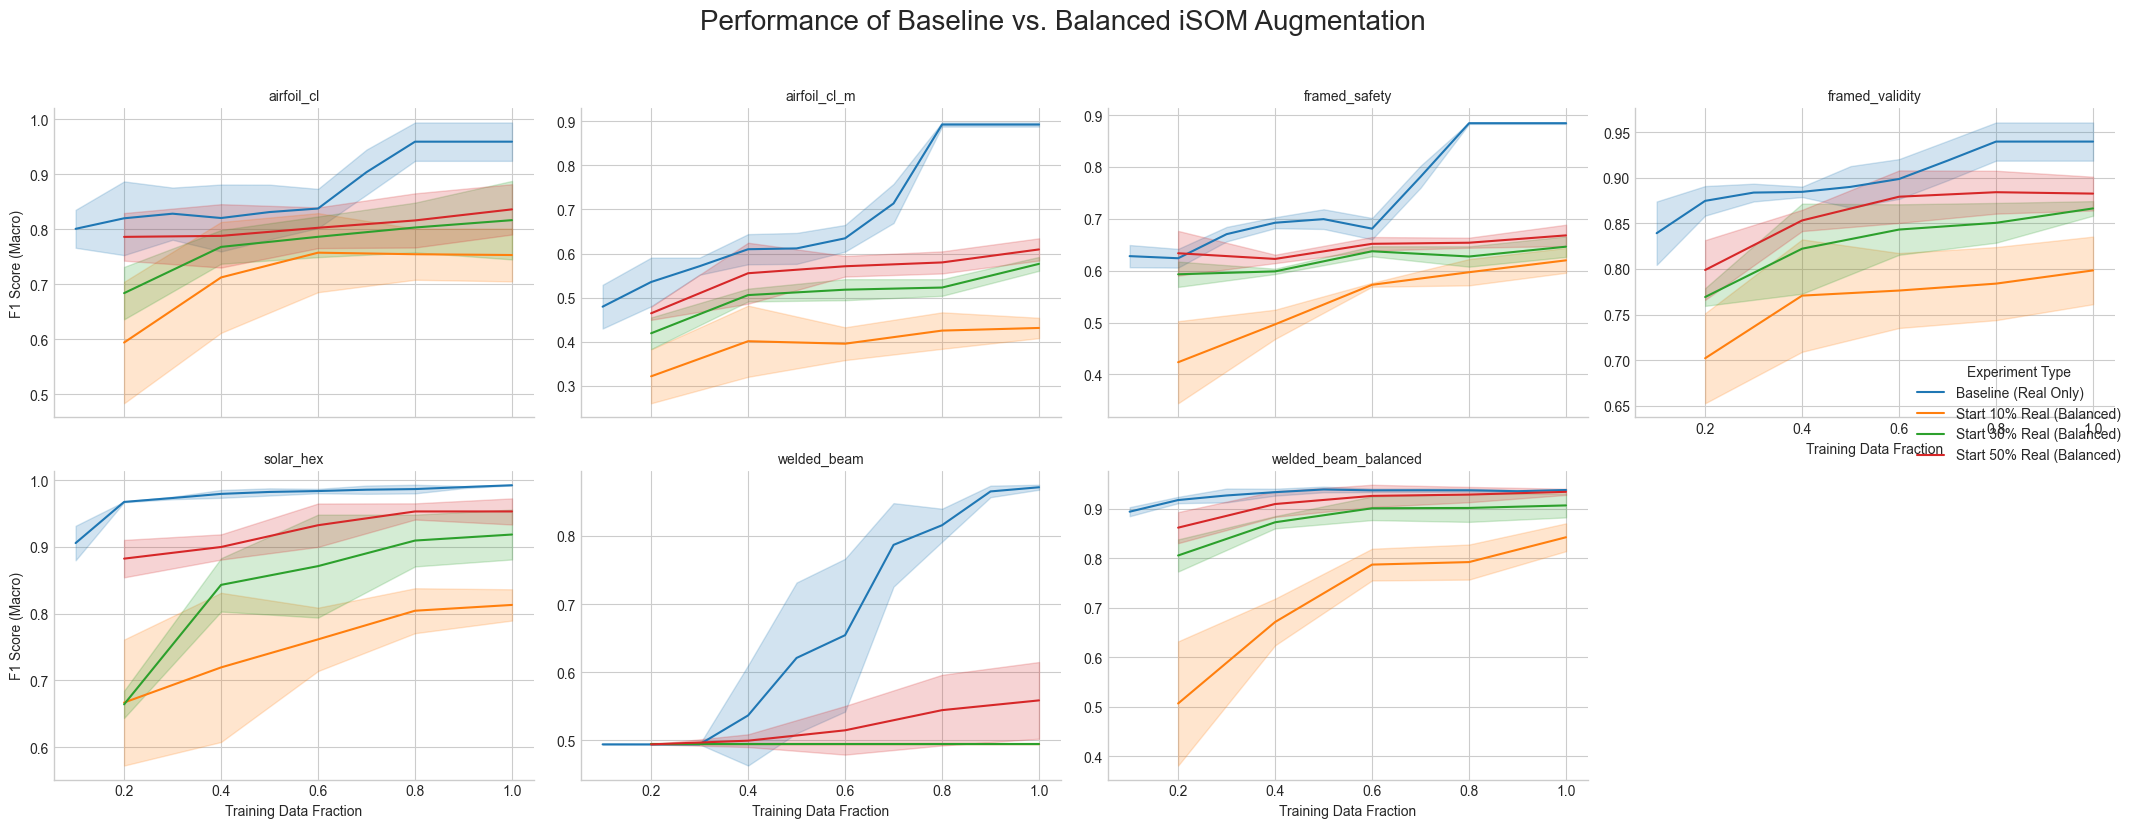

In [13]:
# ===================================================================
# Cell 6: Visualize All Results (Corrected)
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

experiment_order = ["Baseline (Real Only)"] + [f"Start {int(f*100)}% Real (Balanced)" for f in STARTING_REAL_FRACTIONS]

# --- FIX ---
# We define BOTH hue and style in the FacetGrid constructor.
# This lets the grid manage all the visual mappings and legend creation.
g = sns.FacetGrid(
    results_df, 
    col="dataset", 
    col_wrap=4, 
    hue="experiment",
    # style="experiment",  # Define style here
    hue_order=experiment_order,
    # style_order=experiment_order, # Match the style order
    col_order=DATASETS_TO_RUN,
    height=4, 
    aspect=1.2, 
    sharey=False,
    legend_out=True # Ensures legend is placed neatly
)

# --- FIX ---
# The map_dataframe call is now very simple. We just tell it what to plot,
# and FacetGrid handles the rest based on the 'hue' and 'style' mappings.
g.map_dataframe(
    sns.lineplot,
    x="total_fraction",
    y="f1_score",
    markers=True,
    errorbar="sd"
).set_titles("{col_name}")


g.set_axis_labels("Training Data Fraction", "F1 Score (Macro)")
g.fig.suptitle("Performance of Baseline vs. Balanced iSOM Augmentation", y=1.03, fontsize=20)
g.add_legend(title="Experiment Type") # Add a title to the legend

# Adjust the layout to make space for the legend
g.fig.tight_layout()

plt.show()